In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np

In [14]:
def plot_results(df1, df2, y_label='Evaluation Set'):
    unique_values1 = df1['model'].unique()
    unique_values2 = df2['model'].unique()

    resnet_results = df1[df1['model'] == unique_values1[0]]
    xception_results = df1[df1['model'] == unique_values1[1]]
    resnet_results2 = df2[df2['model'] == unique_values2[0]]
    xception_results2 = df2[df2['model'] == unique_values2[1]]

    fig, axes = plt.subplots(2, 2, figsize=(20, 10))  # Create a figure with four subplots

    x_min = .55
    x_max = .9

    for i, plot in enumerate([
        {"df": resnet_results, "model": "ResNet50", "ylabel": "In-Distribution"},
        {"df": xception_results, "model": "Xception", "ylabel": "In-Distribution"},
        {"df": resnet_results2, "model": "", "ylabel": "Out-of-Distribution"},
        {"df": xception_results2, "model": "", "ylabel": "Out-of-Distribution"}
    ]):
        sns.set_style("whitegrid")
        sns.set(font='serif')
        sns.set_style("white", {
            "font.family": "serif",
            "font.serif": ["Times", "Palatino", "serif"],
        })

        params = {
            'axes.labelsize': 12,  # Font size of x and y labels
            'xtick.labelsize': 12,  # Font size of x-axis ticks
            'ytick.labelsize': 12,  # Font size of y-axis ticks
            'legend.title_fontsize': 18,  # Font size of legend
            'legend.markerscale': 3,  # Font size of legend
            'legend.fontsize': 12,  # Font size of legend
        }
        plt.rcParams.update(params)

        ax = sns.pointplot(
            data=plot['df'],
            x='f1-score(weighted avg)',
            y='evaluation_set',
            hue='approach',
            linestyles='none',
            errorbar=("ci", 95),
            dodge=.7,
            err_kws={'linewidth': 3},
            ax=axes[i//2, i%2]
        )

        ax.set_xlabel("f1-score(weighted avg)", fontsize=24)

        ax.set_xlim(x_min, x_max)

        if i % 2 == 0:
            ax.set_ylabel(plot['ylabel'], fontsize=24)
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

        ax.tick_params(labelsize=24)
        ax.set_title(plot['model'], fontsize=24 if plot['model'] else 0)  # Set title size to 0 if model name is empty

        ax.legend_.remove()  # Remove the legend from each subplot

    # Create a single legend below both plots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title="Strategy", loc='lower center', bbox_to_anchor=(0.5, -0.17), fontsize=24, title_fontsize=24, ncol=3)

    plt.tight_layout()
    plt.savefig('../output/aggregate_id_ood_plot.png')
    plt.show()

In [15]:
results = pd.read_csv(f'../results/official_output_29.4_15folds.csv')
results['evaluation_set'] = results['evaluation_set'].str.replace(' 3', '')


results_ood = results[results['evaluation_set'] != 'In-Distribution']
results_in = results[results['evaluation_set'] == 'In-Distribution']

In [16]:
def bootstrap_confidence_interval(data, num_samples=1000, ci=0.95):
    data = np.array(data)

    res = stats.bootstrap((data,), np.mean, confidence_level=ci, n_resamples=num_samples, method='basic')
    return res.confidence_interval.low, res.confidence_interval.high

# In-Distribution Summary

In [17]:
grouped = results_in.groupby(['model', 'approach'])
confidence_intervals = grouped['f1-score(weighted avg)'].apply(lambda x: bootstrap_confidence_interval(x.values))
average_fscore = grouped['f1-score(weighted avg)'].mean()

confidence_intervals_df = pd.DataFrame({
    'Model': confidence_intervals.index.get_level_values('model'),
    'Approach': confidence_intervals.index.get_level_values('approach'),
    'F-Score 95%': [f"{avg:.4f} ({lower:.4f}, {upper:.4f})" for (avg, (lower, upper)) in zip(average_fscore, confidence_intervals)]
})

confidence_intervals_df

,Model,Approach,F-Score 95%
0,ResNet50,Baseline,"0.7106 (0.6880, 0.7333)"
1,ResNet50,DefaultAug,"0.8059 (0.7921, 0.8211)"
2,ResNet50,DefaultAug+Gaussian,"0.8044 (0.7977, 0.8104)"
3,ResNet50,DefaultAug+S&P,"0.8034 (0.7971, 0.8100)"
4,ResNet50,Gaussian,"0.6847 (0.6748, 0.6971)"
5,ResNet50,Salt&Pepper,"0.6604 (0.6428, 0.6768)"
6,Xception,Baseline,"0.7492 (0.7236, 0.7761)"
7,Xception,DefaultAug,"0.8628 (0.8578, 0.8676)"
8,Xception,DefaultAug+Gaussian,"0.8321 (0.8251, 0.8393)"
9,Xception,DefaultAug+S&P,"0.8285 (0.8219, 0.8343)"


-------

# Out of Distribution Summary

In [18]:
grouped = results_ood.groupby(['model', 'approach'])
results_ood.loc[:, 'evaluation_set'] = 'ood'
confidence_intervals = grouped['f1-score(weighted avg)'].apply(lambda x: bootstrap_confidence_interval(x.values))
average_fscore = grouped['f1-score(weighted avg)'].mean()

confidence_intervals_df = pd.DataFrame({
    'Model': confidence_intervals.index.get_level_values('model'),
    'Approach': confidence_intervals.index.get_level_values('approach'),
    'F-Score 95%': [f"{avg:.4f} ({lower:.4f}, {upper:.4f})" for (avg, (lower, upper)) in zip(average_fscore, confidence_intervals)]
})

confidence_intervals_df

,Model,Approach,F-Score 95%
0,ResNet50,Baseline,"0.6046 (0.5946, 0.6163)"
1,ResNet50,DefaultAug,"0.7028 (0.6941, 0.7121)"
2,ResNet50,DefaultAug+Gaussian,"0.7147 (0.7041, 0.7262)"
3,ResNet50,DefaultAug+S&P,"0.7412 (0.7325, 0.7496)"
4,ResNet50,Gaussian,"0.5951 (0.5835, 0.6067)"
5,ResNet50,Salt&Pepper,"0.6021 (0.5931, 0.6114)"
6,Xception,Baseline,"0.6133 (0.6032, 0.6225)"
7,Xception,DefaultAug,"0.7339 (0.7241, 0.7438)"
8,Xception,DefaultAug+Gaussian,"0.7635 (0.7559, 0.7721)"
9,Xception,DefaultAug+S&P,"0.7706 (0.7645, 0.7771)"


# Plots

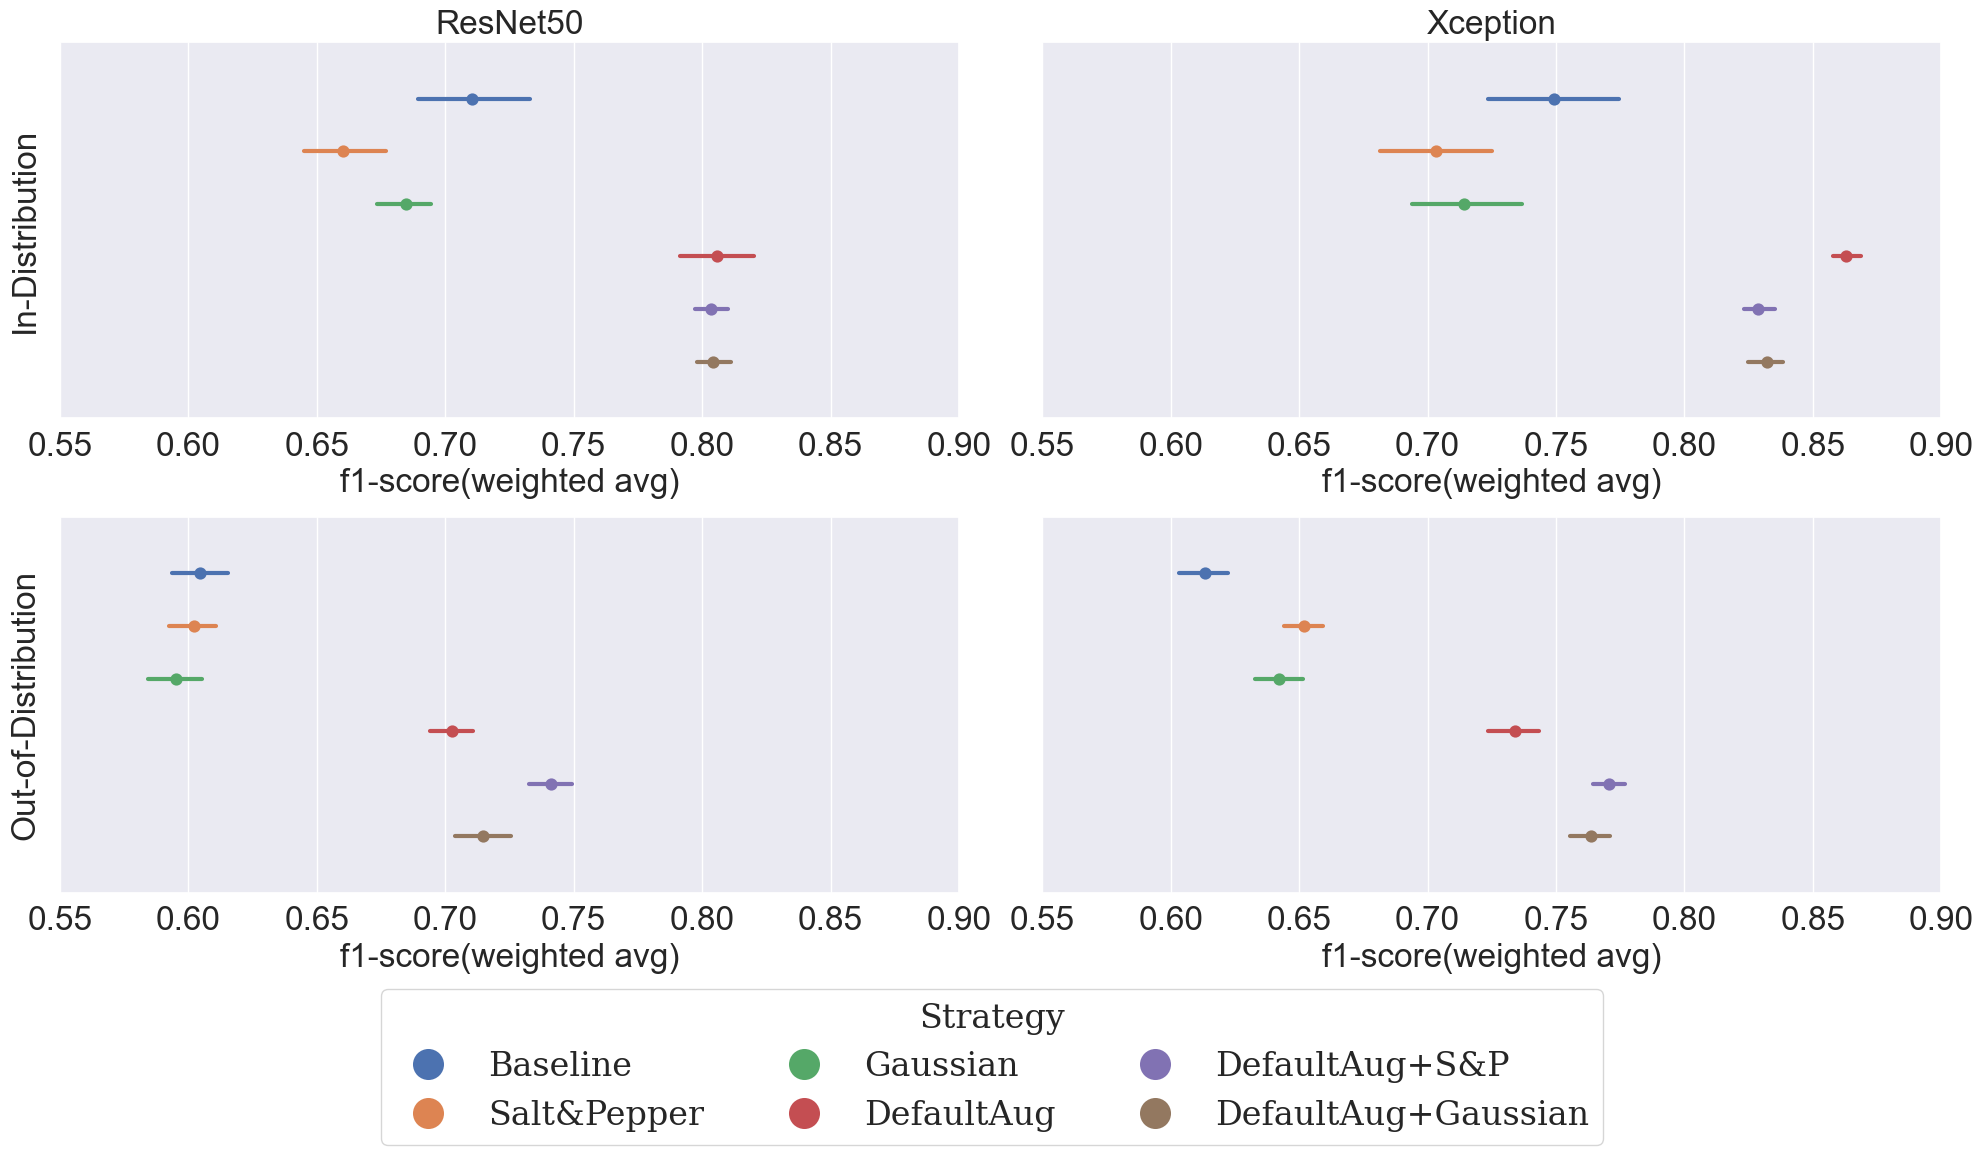

In [19]:
plot_results(results_in, results_ood)